### Setup and Data Ingestion
This cell only handles the API connection, downloading, and fixing the structure of the dataframe.

In [3]:
import yfinance as yf
import pandas as pd
import time

# 1. Configuration
ticker_symbol = "RSP"
start_date = "2003-05-01"

print(f"--- Step 1: Ingesting data for {ticker_symbol} ---")
start_time = time.time()

# 2. Download raw data
# We download everything available to have a clean starting point
raw_data = yf.download(ticker_symbol, start=start_date, progress=True)

# 3. Structural Fix: Flatten MultiIndex columns if present (common in new yfinance versions)
if isinstance(raw_data.columns, pd.MultiIndex):
    raw_data.columns = raw_data.columns.get_level_values(0)

end_time = time.time()
print(f"Download completed in {end_time - start_time:.2f} seconds.")
print(f"Initial Dataset Shape: {raw_data.shape}")

# Inspect the raw structure
raw_data.head()

--- Step 1: Ingesting data for RSP ---


[*********************100%***********************]  1 of 1 completed

Download completed in 0.81 seconds.
Initial Dataset Shape: (5705, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2003-05-01,17.983393,18.048639,17.752383,17.810577,157200
2003-05-02,18.318441,18.318441,17.963994,17.963994,61200
2003-05-05,18.357244,18.436599,18.293761,18.353718,140000
2003-05-06,18.503605,18.588250,18.374874,18.374874,30000
2003-05-07,18.431301,18.563558,18.339604,18.392507,20800


### Data Validation and Target Creation
Now that we are sure the data is in the right format, we create our "Target" (what we want to predict).

In [4]:
# 1. Create a working copy to preserve raw data
data = raw_data.copy()

# 2. Create the Target variable (The "Ground Truth")
# We shift the Close price back by 1 day to see tomorrow's result today
data["Tomorrow"] = data["Close"].shift(-1)

# Target: 1 if price goes UP tomorrow, 0 if it stays the same or goes DOWN
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

# 3. Clean incomplete rows
# The very last row will always have a NaN in 'Tomorrow' because tomorrow hasn't happened yet
data = data.dropna()

print("--- Step 2: Data Validation ---")
print(f"Processed Dataset Shape: {data.shape}")
print(f"Target distribution (0=Down/Flat, 1=Up):\n{data['Target'].value_counts(normalize=True)}")

data.head()

--- Step 2: Data Validation ---
Processed Dataset Shape: (5704, 7)
Target distribution (0=Down/Flat, 1=Up):
Target
1    0.546108
0    0.453892
Name: proportion, dtype: float64


Price,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2003-05-01,17.983393,18.048639,17.752383,17.810577,157200,18.318441,1
2003-05-02,18.318441,18.318441,17.963994,17.963994,61200,18.357244,1
2003-05-05,18.357244,18.436599,18.293761,18.353718,140000,18.503605,1
2003-05-06,18.503605,18.588250,18.374874,18.374874,30000,18.431301,0
2003-05-07,18.431301,18.563558,18.339604,18.392507,20800,18.232033,0


### Visual EDA (Your Visualization Code)
Keep this code exactly as you have it, but let's add one small fix: ensure it uses the data variable from the previous cell.

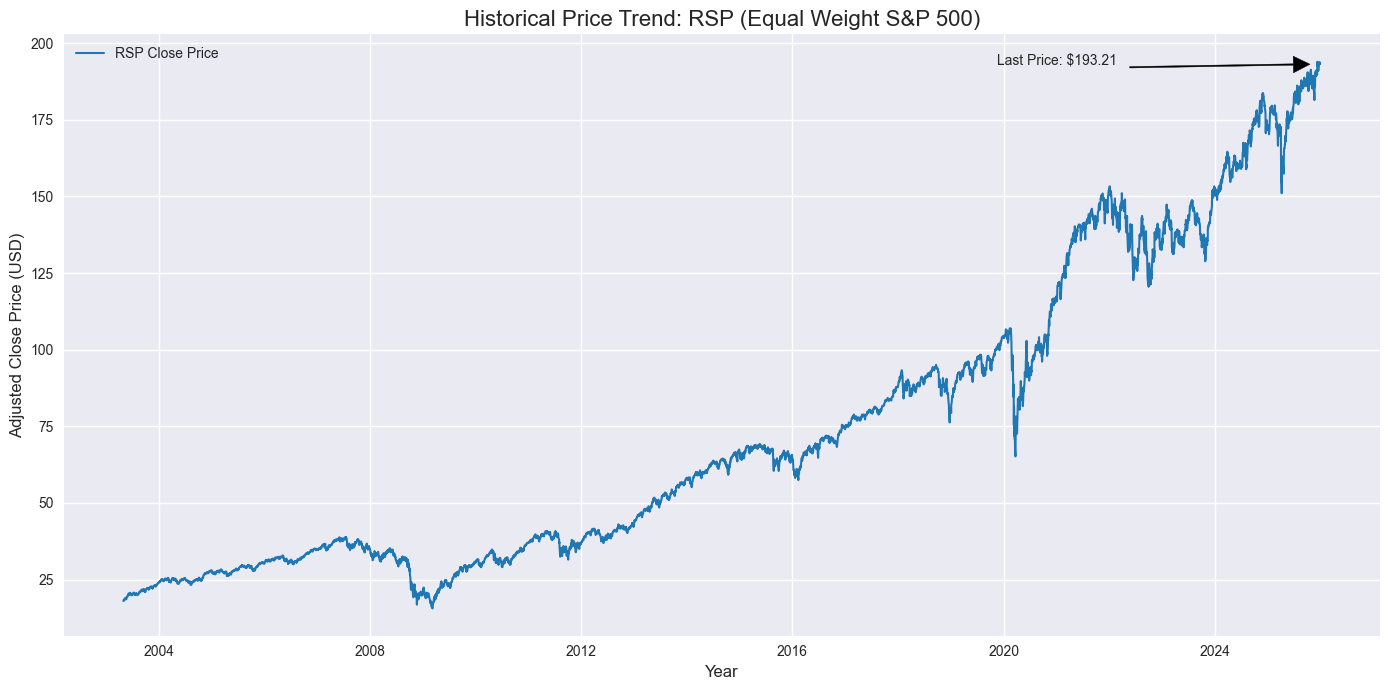

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 2.5: Visual Exploratory Data Analysis ---

# Use 'ggplot' or 'seaborn-v0_8' (if available), otherwise fallback to 'bmh'
available_styles = plt.style.available
if 'seaborn-v0_8' in available_styles:
    plt.style.use('seaborn-v0_8')
elif 'ggplot' in available_styles:
    plt.style.use('ggplot')
else:
    plt.style.use('bmh')

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], color='#1f77b4', linewidth=1.5, label='RSP Close Price')

# Enhance chart with metadata
plt.title(f'Historical Price Trend: {ticker_symbol} (Equal Weight S&P 500)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)

# Highlight key info
plt.legend(loc='upper left')

# Dynamic annotation for the last available price
last_date = data.index[-1]
last_price = float(data["Close"].iloc[-1])

plt.annotate(f'Last Price: ${last_price:.2f}', 
             xy=(last_date, last_price),
             xytext=(0.8, 0.95), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             horizontalalignment='right')

plt.tight_layout()
plt.show()

### Technical Indicators & Feature Engineering
In this cell, we will calculate rolling averages and price ratios. This allows the model to compare the current price to its historical performance over different time horizons.

In [7]:
import numpy as np
from tqdm.auto import tqdm

print("--- Step 3: Feature Engineering (Technical Indicators) ---")

# 1. Define time horizons (trading days)
# 2: Ultra short-term
# 5: One trading week
# 60: One trading quarter
# 250: One trading year
# 1000: Long-term trend (~4 years)
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

# 2. Loop through horizons with a progress bar
for horizon in tqdm(horizons, desc="Generating Technical Features"):
    # Calculate Rolling Average
    rolling_averages = data["Close"].rolling(horizon).mean()
    
    # Feature 1: Close Price Ratio
    # (Today's Close / Average Close of the period)
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages
    
    # Feature 2: Trend
    # (Sum of positive days in the last 'X' days)
    # We shift(1) to ensure we only use PAST data to predict the future
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data["Target"].shift(1).rolling(horizon).sum()
    
    new_predictors += [ratio_column, trend_column]

# 3. Final Cleaning
# Rolling windows create NaN values at the beginning of the dataset
# (e.g., the 1000-day window needs 1000 days of data before it can calculate a value)
data_prepared = data.dropna().copy()

print(f"Feature Engineering Complete.")
print(f"Final Dataset Shape: {data_prepared.shape}")
print(f"Predictors created: {new_predictors}")

# Show the last 5 rows of the new features
data_prepared[new_predictors].tail()

c:\Users\gabri_7a484pu\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Step 3: Feature Engineering (Technical Indicators) ---


Generating Technical Features: 100%|██████████| 5/5 [00:00<00:00, 620.11it/s]

Feature Engineering Complete.
Final Dataset Shape: (4704, 17)
Predictors created: ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']


Price,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,
2025-12-23,0.998836,1.0,1.004448,3.0,1.022619,35.0,1.074950,130.0,1.242806,520.0
2025-12-24,1.001809,1.0,1.005182,4.0,1.025888,35.0,1.078386,130.0,1.246976,521.0
2025-12-26,1.000129,2.0,1.002922,4.0,1.025749,35.0,1.078209,130.0,1.246961,522.0
2025-12-29,0.999174,1.0,0.999814,3.0,1.023722,34.0,1.075954,130.0,1.244571,521.0
2025-12-30,0.999198,0.0,0.998553,2.0,1.021837,33.0,1.073722,130.0,1.242259,520.0
